<a href="https://colab.research.google.com/github/MasonRiley/idc6210_capstone/blob/main/RRP_Analytics_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Here is the link to RRP Analytics' Video Presentation on Customer Churn:

# 1.  Load all of the necessary libraries

In [391]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder


# 2. Load the Datasets

In [264]:
# Next we Loaded our dataset
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

# Here we displayed the first few rows(little peek at our datasets)
print(train_data.head())
print(test_data.head())

# Again just gaining more basic information on the nature of our data
print(train_data.info())
print(test_data.describe())


     id  gender  senior_citizen partner dependents  tenure phone_service  \
0  1815    Male               0     Yes        Yes      12           Yes   
1  5947  Female               0      No         No      42           Yes   
2  3882    Male               0     Yes         No      71           Yes   
3  2390    Male               0     Yes        Yes      71           Yes   
4  3677    Male               0      No         No      30           Yes   

  multiple_lines internet_service      online_security  ...  \
0             No               No  No internet service  ...   
1             No              DSL                  Yes  ...   
2            Yes              DSL                  Yes  ...   
3            Yes              DSL                  Yes  ...   
4             No              DSL                  Yes  ...   

     device_protection         tech_support         streaming_tv  \
0  No internet service  No internet service  No internet service   
1                  Yes      

# 3. Data Exploration

id                   0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
label                0
dtype: int64
id                   0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64
                id  senior_citi

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Transformed training data:
     id  senior_citizen  tenure  monthly_charges  label  gender_Male  \
0  1815               0      12            19.70      0          1.0   
1  5947               0      42            73.90      1          0.0   
2  3882               0      71            65.15      0          1.0   
3  2390               0      71            85.45      0          1.0   
4  3677               0      30            70.40      0          1.0   

   partner_Yes  dependents_Yes  phone_service_Yes  \
0          1.0             1.0                1.0   
1          0.0             0.0                1.0   
2          1.0             0.0                1.0   
3          1.0             1.0                1.0   
4          0.0             0.0                1.0   

   multiple_lines_No phone service  ...  total_charges_994.55  \
0                              0.0  ...                   0.0   
1                              0.0  ...                   0.0   
2                         

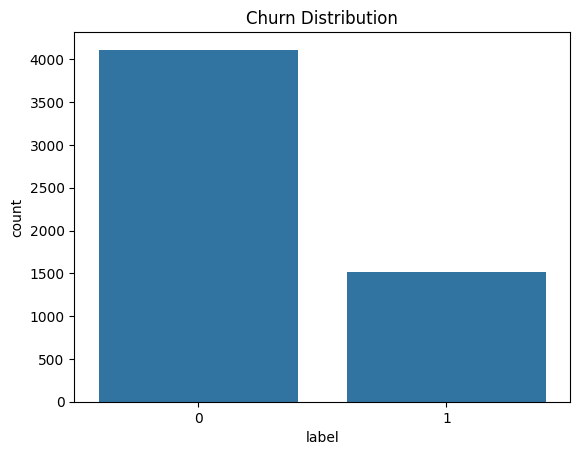

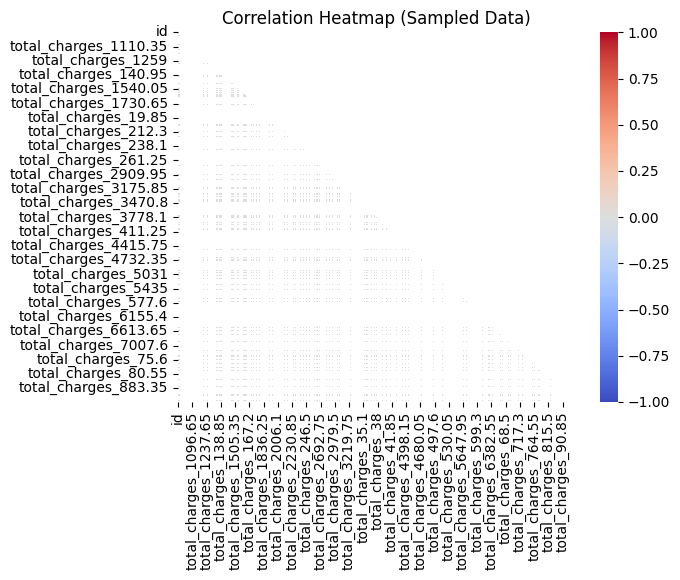

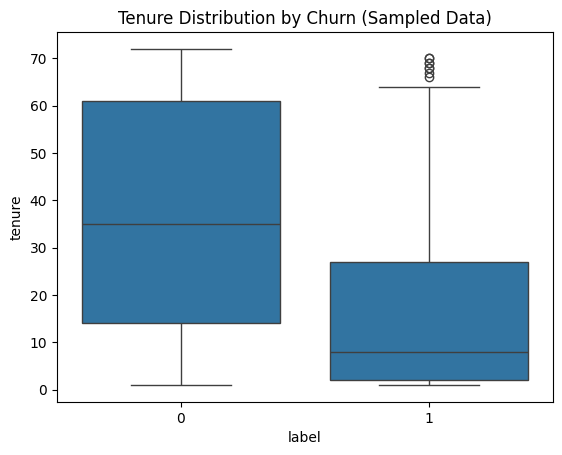

Correlation Matrix:
                            id  senior_citizen    tenure  monthly_charges  \
id                    1.000000        0.014704  0.003617        -0.023486   
senior_citizen        0.014704        1.000000  0.023443         0.225234   
tenure                0.003617        0.023443  1.000000         0.251072   
monthly_charges      -0.023486        0.225234  0.251072         1.000000   
label                 0.013765        0.141966 -0.351885         0.196805   
...                        ...             ...       ...              ...   
total_charges_997.65  0.017427        0.030318 -0.011547         0.013443   
total_charges_997.75  0.020478       -0.005856  0.010160        -0.020086   
total_charges_998.1   0.013632       -0.005856  0.012330        -0.020196   
total_charges_999.45  0.001142       -0.005856 -0.010461         0.004524   
total_charges_999.9  -0.004352       -0.005856 -0.011547         0.013022   

                         label  gender_Male  partner_Ye

In [5]:
# Here we checked for missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# Here we wanted to see the distribution of
#our data via summary statistics
print(train_data.describe())
print(test_data.describe())

# Here we identified our nominal features
nominal_features = train_data.select_dtypes(include=['object', 'category']).columns
print(nominal_features)

# Next we One-hot encoded our nominal features in the train data set
one_hot_encoded = OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore')
train_encoded = pd.DataFrame(
    one_hot_encoded.fit_transform(train_data[nominal_features]),
    columns=one_hot_encoded.get_feature_names_out(nominal_features),
    index=train_data.index
)

# Next we One-hot encoded our nominal features in the test data set
test_encoded = pd.DataFrame(
    one_hot_encoded.transform(test_data[nominal_features]),
    columns=one_hot_encoded.get_feature_names_out(nominal_features),
    index=test_data.index)

# Next we dropped the original nominal features and
#concatenate the encoded features
train_data = pd.concat([train_data.drop(columns=nominal_features),
                        train_encoded], axis=1)
test_data = pd.concat([test_data.drop(columns=nominal_features), test_encoded],
                      axis=1)

# Here we verified that the data has been transformed correctly
print("Transformed training data:")
print(train_data.head())
print("Transformed testing data:")
print(test_data.head())

# Now we visualize the distribution of our target variable
sns.countplot(x='label', data=train_data)
plt.title("Churn Distribution")
plt.show()

# We selected a sub-set of numerical features(run-time on full set too long)
numerical_features = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data_subset = train_data[numerical_features]

# Reduced feature set or sampled rows
train_data_sampled = train_data_subset.sample(1000, random_state=42)

# Compute and plot the correlation heatmap
corr = train_data_sampled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=False, cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap (Sampled Data)")
plt.show()

# Plot a boxplot with sampled data
sns.boxplot(x='label', y='tenure', data=train_data_sampled)
plt.title("Tenure Distribution by Churn (Sampled Data)")
plt.show()

# Here we computed the correlation matrix
corr_matrix = train_data_subset.corr()
print("Correlation Matrix:")
print(corr_matrix)




In [6]:
print(train_data.columns)

Index(['id', 'senior_citizen', 'tenure', 'monthly_charges', 'label',
       'gender_Male', 'partner_Yes', 'dependents_Yes', 'phone_service_Yes',
       'multiple_lines_No phone service',
       ...
       'total_charges_994.55', 'total_charges_994.8', 'total_charges_995.35',
       'total_charges_996.45', 'total_charges_996.85', 'total_charges_997.65',
       'total_charges_997.75', 'total_charges_998.1', 'total_charges_999.45',
       'total_charges_999.9'],
      dtype='object', length=5321)


# 4. Data Preprocessing

In [414]:
# Import necessary libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1: Here we define the features (X) and target variable (y)
X = train_data.drop(columns=['label', 'id'])  # Here we dropped the target column 'label' and 'id' column
#X = train_data[['total_charges', 'monthly_charges', 'tenure', 'contract']]  # Here we dropped the target column 'label' and 'id' column
y = train_data['label']  # Target variable 'label'

# 2: Here we saved the 'id' columns before dropping them for submission
train_ids = train_data['id']  # Preserve 'id' from train_data
test_ids = test_data['id']  # Preserve 'id' from test_data

# 3: Here we dropped 'id' column from the feature set (X) before processing
X_test = test_data.drop(columns=['id'])  # Drop 'id' from test data

# 4: Here we identified the categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# 5: Here we  preprocessed pipelines for numerical and categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values
    ('scaler', StandardScaler())  # Standardize numerical features
])

# 6: Here we made transformations into a single preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),  # Apply numerical transformer to numerical columns
        ('cat', categorical_transformer, categorical_cols)  # Apply categorical transformer to categorical columns
    ]
)

# 7: Here we split the dataset into training and test sets (using stratified splitting to preserve label distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 8:Finally, we preprocessed the training and test sets
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#Ensure test_ids matches the number of predictions (during deployment stage)
X

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,Male,0,Yes,Yes,12,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35
1,Female,0,No,No,42,Yes,No,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,3160.55
2,Male,0,Yes,No,71,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,4681.75
3,Male,0,Yes,Yes,71,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,6300.85
4,Male,0,No,No,30,Yes,No,DSL,Yes,Yes,No,Yes,Yes,No,One year,No,Electronic check,70.40,2044.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,Male,1,No,No,9,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,100.50,918.6
5630,Male,0,No,Yes,60,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.95,1189.9
5631,Male,0,No,No,28,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,105.70,2979.5
5632,Male,0,No,No,2,Yes,Yes,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,54.40,114.1


In [437]:
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='auc',       # Evaluation metric
    n_estimators=5000,            # Number of trees
    learning_rate=0.001,           # Step size shrinkage
    max_depth=1000,                 # Max depth of trees
    subsample=0.8,               # Fraction of samples to grow trees
    colsample_bytree=0.8,         # Fraction of features per tree
    gamma=10.0,
    min_child_weight=5
)

# XGB Classifier
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# First, we train the model
xgb_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_xgb = xgb_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb, average='binary')  # Use 'binary' for binary classification

print("XGB Accuracy:", accuracy)
print("XGB F1-Score:", f1)


XGB Accuracy: 0.8065661047027507
XGB F1-Score: 0.5932835820895522


# 5. Model Training

## Logistic Regression

### Default Model

In [305]:
# Logistic Regression Classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)



Logistic Regression Accuracy: 0.7950310559006211
Logistic Regression F1-Score: 0.5761467889908257


### Top Performer - No Feature Selection

In [306]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=0.3, solver='lbfgs', max_iter=10000)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.7959183673469388
Logistic Regression F1-Score: 0.5787545787545788


### Top Performer - With Feature Selection

In [389]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=0.006, solver='lbfgs', max_iter=10000)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.8039041703637977
Logistic Regression F1-Score: 0.5307855626326964


### LR Testing Range

In [370]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=0.009, solver='lbfgs', max_iter=10000)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.8012422360248447
Logistic Regression F1-Score: 0.5465587044534413


In [384]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=100, solver='liblinear', max_iter=10000, dual=True, class_weight='balanced')

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)
# ---------------------

Logistic Regression Accuracy: 0.774622892635315
Logistic Regression F1-Score: 0.5849673202614379


In [309]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=., solver='sag', max_iter=10000)

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.7941437444543035
Logistic Regression F1-Score: 0.5781818181818181


In [310]:
# Logistic Regression Classifier
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# First, we train the model
lr_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.7950310559006211
Logistic Regression F1-Score: 0.5761467889908257


## Decision Tree

### Default Model

In [311]:
# Decision Tree Classifier
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))  # Added random_state for reproducibility
])

# First, we train the model
dt_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_dt = dt_pipeline.predict(X_test)

# Finally, we evaluation metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='binary')  # Use 'binary' for binary classification

print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree F1-Score:", dt_f1)



Decision Tree Accuracy: 0.7675244010647737
Decision Tree F1-Score: 0.5467128027681661


### Top Performer

In [385]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(criterion='gini', min_samples_split=2, min_samples_leaf=1)

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', dt)  # Added random_state for reproducibility
])

# First, we train the model
dt_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_dt = dt_pipeline.predict(X_test)

# Finally, we evaluation metrics
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt, average='binary')  # Use 'binary' for binary classification

print("Decision Tree Accuracy:", dt_accuracy)
print("Decision Tree F1-Score:", dt_f1)



Decision Tree Accuracy: 0.7701863354037267
Decision Tree F1-Score: 0.5557461406518011


In [386]:
# Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# First, we train the model
rf_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_rf = rf_pipeline.predict(X_test)

# Finally, we evaluation metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='binary')  # Use 'binary' for binary classification

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest F1-Score:", rf_f1)



Random Forest Accuracy: 0.7950310559006211
Random Forest F1-Score: 0.5217391304347826


# SVM

### Default Model

In [314]:
# Support Vector Machine (SVM) Classifier
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))  # Default kernel is 'rbf'
])

# First, we train the model
svm_pipeline.fit(X_train, y_train)

# Next, we predict on the test set
y_pred_svm = svm_pipeline.predict(X_test)

# Finally, we evaluation Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='binary')  # Use 'binary' for binary classification

print("SVM Accuracy:", svm_accuracy)
print("SVM F1-Score:", svm_f1)



SVM Accuracy: 0.7879325643300799
SVM F1-Score: 0.5447619047619048


### Top Performer

In [344]:
# Support Vector Machine (SVM) Classifier
svm = SVC(kernel='linear', C=1, gamma='auto')

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm)  # Default kernel is 'rbf'
])

# First, we train the model
svm_pipeline.fit(X_train, y_train)

# Next, we predict on the test set
y_pred_svm = svm_pipeline.predict(X_test)

# Finally, we evaluation Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='binary')  # Use 'binary' for binary classification

print("SVM Accuracy:", svm_accuracy)
print("SVM F1-Score:", svm_f1)



SVM Accuracy: 0.7914818101153505
SVM F1-Score: 0.5623836126629422


In [355]:
# Support Vector Machine (SVM) Classifier
svm = SVC(kernel='linear', C=0.1, gamma='scale')

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm)  # Default kernel is 'rbf'
])

# First, we train the model
svm_pipeline.fit(X_train, y_train)

# Next, we predict on the test set
y_pred_svm = svm_pipeline.predict(X_test)

# Finally, we evaluation Metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='binary')  # Use 'binary' for binary classification

print("SVM Accuracy:", svm_accuracy)
print("SVM F1-Score:", svm_f1)



SVM Accuracy: 0.7994676131322094
SVM F1-Score: 0.597864768683274


In [357]:
from sklearn.model_selection import GridSearchCV

# First, we defined the hyperparameter grid to tune
param_grid = {
    'classifier__n_neighbors': [5, 10, 15, 20, 25],  # Number of trees in the forest
    'classifier__weights': ['uniform', 'distance'],  # Max depth of the tree
    'classifier__algorithm': ['ball_tree', 'kd_tree'],  # Minimum samples required to split an internal node
    'classifier__leaf_size': [10, 20, 30, 40, 50]  # Minimum samples required to be at a leaf node
}

# Next, we apend Random Forest Classifier Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())  # Default n_neighbors is 5
])

# Next, we set up the GridSearchCV with 3-fold cross-validation and 'f1_macro' scoring
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

# Next, we fit the model using grid search
grid_search.fit(X_train, y_train)

# Next, we get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score (Macro):", grid_search.best_score_)

# Finally, use the best model to make predictions and evaluate
best_knn_model = grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='binary')

print("KNN Accuracy after Tuning:", knn_accuracy)
print("KNN F1-Score after Tuning:", knn_f1)



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Best Parameters: {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}
Best F1-Score (Macro): 0.7050751973246348
KNN Accuracy after Tuning: 0.7914818101153505
KNN F1-Score after Tuning: 0.573502722323049


In [387]:
# K-Nearest Neighbors (KNN) Classifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())  # Default n_neighbors is 5
])

# First, we train the model
knn_pipeline.fit(X_train, y_train)

# Next, we predict on the test set
y_pred_knn = knn_pipeline.predict(X_test)

# Finally, we evaluate Metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='binary')  # Use 'binary' for binary classification

print("KNN Accuracy:", knn_accuracy)
print("KNN F1-Score:", knn_f1)




KNN Accuracy: 0.7950310559006211
KNN F1-Score: 0.5896980461811723


In [326]:
from sklearn.model_selection import GridSearchCV

# First, we defined the hyperparameter grid to tune
param_grid = {
    'classifier__n_neighbors': [5, 10, 15, 20, 25],  # Number of trees in the forest
    'classifier__weights': ['uniform', 'distance'],  # Max depth of the tree
    'classifier__algorithm': ['ball_tree', 'kd_tree'],  # Minimum samples required to split an internal node
    'classifier__leaf_size': [10, 20, 30, 40, 50]  # Minimum samples required to be at a leaf node
}

# Next, we apend Random Forest Classifier Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())  # Default n_neighbors is 5
])

# Next, we set up the GridSearchCV with 3-fold cross-validation and 'f1_macro' scoring
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

# Next, we fit the model using grid search
grid_search.fit(X_train, y_train)

# Next, we get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score (Macro):", grid_search.best_score_)

# Finally, use the best model to make predictions and evaluate
best_knn_model = grid_search.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='binary')

print("KNN Accuracy after Tuning:", knn_accuracy)
print("KNN F1-Score after Tuning:", knn_f1)



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:583: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


Best Parameters: {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}
Best F1-Score (Macro): 0.7050751973246348
KNN Accuracy after Tuning: 0.7914818101153505
KNN F1-Score after Tuning: 0.573502722323049


In [325]:
# K-Nearest Neighbors (KNN) Classifier

knn = KNeighborsClassifier(n_neighbors=11,
                           n_jobs=-1)

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', knn)  # Default n_neighbors is 5
])

# First, we train the model
knn_pipeline.fit(X_train, y_train)

# Next, we predict on the test set
y_pred_knn = knn_pipeline.predict(X_test)

# Finally, we evaluate Metrics
knn_accuracy = accuracy_score(y_test, y_pred_knn)
knn_f1 = f1_score(y_test, y_pred_knn, average='binary')  # Use 'binary' for binary classification

print("KNN Accuracy:", knn_accuracy)
print("KNN F1-Score:", knn_f1)

KNN Accuracy: 0.7968056787932565
KNN F1-Score: 0.5961199294532628


# 6. Hyper Parameter Tuning using Random Forest as an Example

In [173]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# First, we defined the hyperparameter grid to tune
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20, 30],  # Max depth of the tree
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum samples required to be at a leaf node
}

# Next, we apend Random Forest Classifier Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # here we applied the preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42))
])

# Next, we set up the GridSearchCV with 3-fold cross-validation and 'f1_macro' scoring
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)

# Next, we fit the model using grid search
grid_search.fit(X_train, y_train)

# Next, we get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score (Macro):", grid_search.best_score_)

# Finally, use the best model to make predictions and evaluate
best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='binary')

print("Random Forest Accuracy after Tuning:", rf_accuracy)
print("Random Forest F1-Score after Tuning:", rf_f1)



KeyboardInterrupt: 

In [388]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators=2000,
                                criterion='log_loss',
                                random_state=1,
                                n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', forest)
])

# First, we train the model
rf_pipeline.fit(X_train, y_train)

# Next, we predict and evaluate
y_pred_rf = rf_pipeline.predict(X_test)

# Finally, we evaluation metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, average='binary')  # Use 'binary' for binary classification

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest F1-Score:", rf_f1)

Random Forest Accuracy: 0.7994676131322094
Random Forest F1-Score: 0.540650406504065


# Hyper Parameter Tuning using the Logestic Regression Classifier

In [15]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Here we defined the hyperparameter grid with conditional constraints for solvers
param_dist = {
    'classifier__penalty': ['l1', 'l2'],  # Regularization type (L1 or L2)
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength (more values for better search)
    'classifier__max_iter': [100, 200, 300],  # Max number of iterations for convergence
    'classifier__tol': [1e-4, 1e-3, 1e-2],  # Tolerance for stopping criteria (balance between speed and accuracy)
    'classifier__class_weight': [None, 'balanced'],  # Adjust class weight if class imbalance exists
}

# For the liblinear solver, we allow only 'l1' and 'l2' penalties
param_dist['classifier__solver'] = ['liblinear']

# For newton-cg and lbfgs solvers, we restrict penalties to 'l2'
param_dist.update({
    'classifier__penalty': ['l2'],  # Only 'l2' for these solvers
    'classifier__solver': ['newton-cg', 'lbfgs'],
})

# Logistic Regression Classifier Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(warm_start=True))  # Logistic Regression Classifier with warm_start
])

# Set up the StratifiedKFold and RandomizedSearchCV with 'f1_macro' scoring
cv = StratifiedKFold(n_splits=3)  # Ensures each fold has a similar distribution of classes
random_search = RandomizedSearchCV(
    lr_pipeline, param_distributions=param_dist, n_iter=30, cv=cv, scoring='f1_macro', n_jobs=-1, random_state=42
)

# Here we it the model using randomized search
random_search.fit(X_train, y_train)

# Next, we get the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best F1-Score (Macro):", random_search.best_score_)

# Nextwe, use the best model to make predictions and evaluate
best_lr_model = random_search.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

# Finally, we evaluate model performance
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, average='macro')  # Use 'macro' for balanced multi-class performance

print("Logistic Regression Accuracy after Tuning:", lr_accuracy)
print("Logistic Regression F1-Score after Tuning:", lr_f1)







Best Parameters: {'classifier__tol': 0.0001, 'classifier__solver': 'newton-cg', 'classifier__penalty': 'l2', 'classifier__max_iter': 300, 'classifier__class_weight': 'balanced', 'classifier__C': 0.001}
Best F1-Score (Macro): 0.7319500758839604
Logistic Regression Accuracy after Tuning: 0.7639751552795031
Logistic Regression F1-Score after Tuning: 0.7034938004921626


# 7. Learning Curve Visualization for Logestic Regression

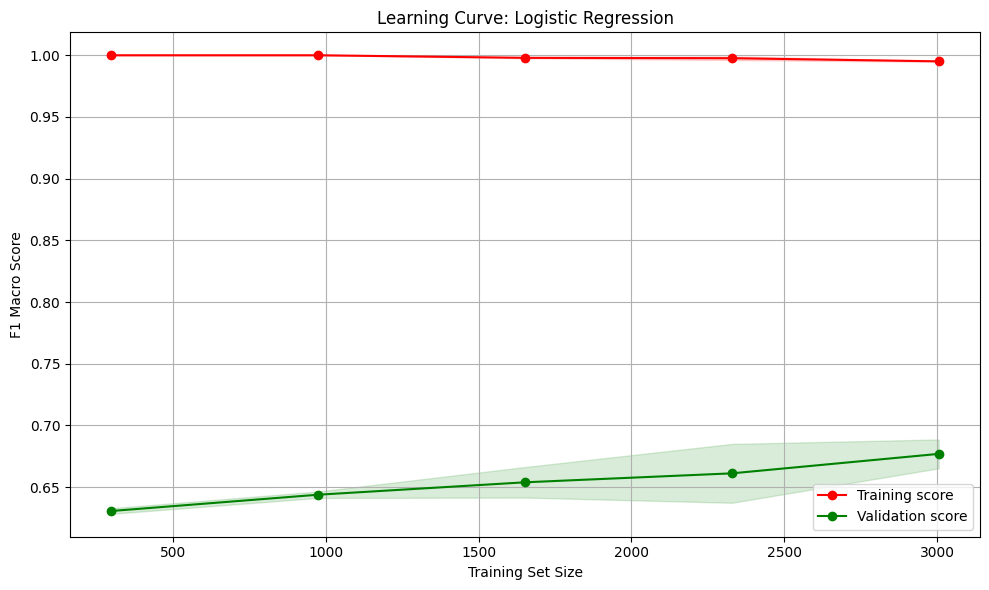

In [16]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

def plot_learning_curve(estimator, X, y, cv=3, scoring='f1_macro'):
    """
    Plot the learning curve for a given estimator.

    Parameters:
    - estimator: The machine learning pipeline or model.
    - X: Feature matrix (training data).
    - y: Target variable.
    - cv: Number of cross-validation folds (default: 3).
    - scoring: Scoring metric (default: 'f1_macro').
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plotting the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.15, color="r")

    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.15, color="g")

    plt.title('Learning Curve: Logistic Regression')
    plt.xlabel('Training Set Size')
    plt.ylabel('F1 Macro Score')
    plt.grid()
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Logistic Regression pipeline (already defined)
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessor is already defined
    ('classifier', LogisticRegression())
])

# Plot learning curve for Logistic Regression pipeline
plot_learning_curve(lr_pipeline, X_train, y_train)





# 7.1 Logistic Regression Validation Curve

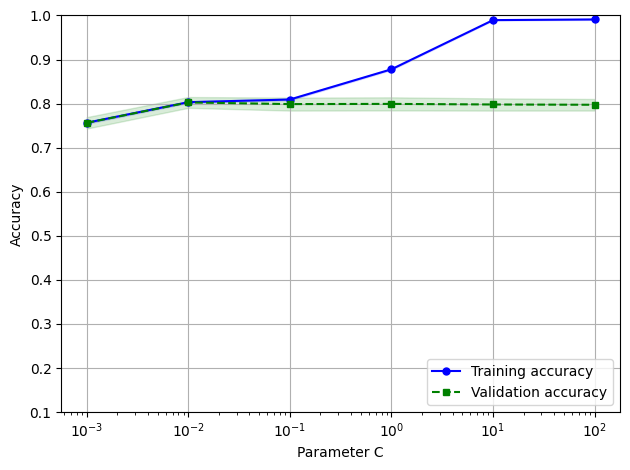

In [123]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

pipe_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),  # here we applied the preprocessing steps
    ('classifier', LogisticRegression(random_state=42, max_iter=10000))
])

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train,
                y=y_train,
                param_name='classifier__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.0])
plt.tight_layout()
plt.show()

In [129]:
feat_labels = train_data.columns[1:]
feat_labels

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'label'],
      dtype='object')

In [131]:
X_train

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
5520,Female,0,Yes,Yes,2,Yes,No,DSL,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,65.70,134.35
5622,Male,0,No,No,36,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),18.55,689
4688,Male,0,No,No,57,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),20.55,1252.85
5415,Female,1,No,No,59,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,89.75,5496.9
4719,Male,1,Yes,Yes,68,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),19.50,1193.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,Female,0,No,No,19,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.90,367.55
2237,Male,0,No,Yes,29,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.85,535.05
158,Male,1,Yes,No,10,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,85.55,851.75
1374,Male,0,Yes,No,24,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.05,2391.8


In [296]:
train_data_encoded = train_data.drop(columns=['label', 'id'])
#train_data_encoded = train_data[['gender', 'partner', 'senior_citizen']]
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['gender']))}
train_data_encoded['gender'] = train_data['gender'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['partner']))}
train_data_encoded['partner'] = train_data['partner'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['dependents']))}
train_data_encoded['dependents'] = train_data['dependents'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['phone_service']))}
train_data_encoded['phone_service'] = train_data['phone_service'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['multiple_lines']))}
train_data_encoded['multiple_lines'] = train_data['multiple_lines'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['internet_service']))}
train_data_encoded['internet_service'] = train_data['internet_service'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['online_security']))}
train_data_encoded['online_security'] = train_data['online_security'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['online_backup']))}
train_data_encoded['online_backup'] = train_data['online_backup'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['device_protection']))}
train_data_encoded['device_protection'] = train_data['device_protection'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['tech_support']))}
train_data_encoded['tech_support'] = train_data['tech_support'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['streaming_tv']))}
train_data_encoded['streaming_tv'] = train_data['streaming_tv'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['streaming_movies']))}
train_data_encoded['streaming_movies'] = train_data['streaming_movies'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['contract']))}
train_data_encoded['contract'] = train_data['contract'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['paperless_billing']))}
train_data_encoded['paperless_billing'] = train_data['paperless_billing'].map(_class_mapping)
_class_mapping = {label: idx for idx, label in enumerate(np.unique(train_data['payment_method']))}
train_data_encoded['payment_method'] = train_data['payment_method'].map(_class_mapping)
train_data_encoded

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,1,0,1,1,12,1,0,2,1,1,1,1,1,1,2,0,3,19.70,258.35
1,0,0,0,0,42,1,0,0,2,2,2,2,0,2,1,0,1,73.90,3160.55
2,1,0,1,0,71,1,2,0,2,2,0,2,0,0,2,0,0,65.15,4681.75
3,1,0,1,1,71,1,2,0,2,0,2,2,2,2,1,0,2,85.45,6300.85
4,1,0,0,0,30,1,0,0,2,2,0,2,2,0,1,0,2,70.40,2044.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,1,1,0,0,9,1,2,1,0,0,2,0,2,2,0,1,2,100.50,918.6
5630,1,0,0,1,60,1,0,2,1,1,1,1,1,1,2,0,3,19.95,1189.9
5631,1,0,0,0,28,1,2,1,0,2,2,0,2,2,0,1,2,105.70,2979.5
5632,1,0,0,0,2,1,2,0,0,2,0,0,0,0,0,1,3,54.40,114.1


In [300]:
# Partition datasets
from sklearn.model_selection import train_test_split

# 1: Here we define the features (X) and target variable (y)
X = train_data_encoded  # Here we dropped the target column 'label' and 'id' column
y = train_data['label']  # Target variable 'label'

for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)

X = train_data_encoded.values  # Here we dropped the target column 'label' and 'id' column
y = train_data['label'].values  # Target variable 'label'

# Split out training & test sets from `train.csv` data
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)



stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_encoded)
X_test_std = stdsc.transform(X_test_encoded)
train_data_encoded

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
0,1,0,1,1,12,1,0,2,1,1,1,1,1,1,2,0,3,19.70,258.35
1,0,0,0,0,42,1,0,0,2,2,2,2,0,2,1,0,1,73.90,3160.55
2,1,0,1,0,71,1,2,0,2,2,0,2,0,0,2,0,0,65.15,4681.75
3,1,0,1,1,71,1,2,0,2,0,2,2,2,2,1,0,2,85.45,6300.85
4,1,0,0,0,30,1,0,0,2,2,0,2,2,0,1,0,2,70.40,2044.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,1,1,0,0,9,1,2,1,0,0,2,0,2,2,0,1,2,100.50,918.60
5630,1,0,0,1,60,1,0,2,1,1,1,1,1,1,2,0,3,19.95,1189.90
5631,1,0,0,0,28,1,2,1,0,2,2,0,2,2,0,1,2,105.70,2979.50
5632,1,0,0,0,2,1,2,0,0,2,0,0,0,0,0,1,3,54.40,114.10


 1) total_charges                  0.183886
 2) monthly_charges                0.177609
 3) tenure                         0.162803
 4) contract                       0.078967
 5) payment_method                 0.049421
 6) online_security                0.045852
 7) tech_support                   0.037629
 8) internet_service               0.029829
 9) paperless_billing              0.027106
10) gender                         0.026805
11) online_backup                  0.026722
12) partner                        0.024846
13) device_protection              0.024008
14) multiple_lines                 0.023540
15) senior_citizen                 0.020997
16) dependents                     0.019118
17) streaming_movies               0.018517
18) streaming_tv                   0.016992
19) phone_service                  0.005354


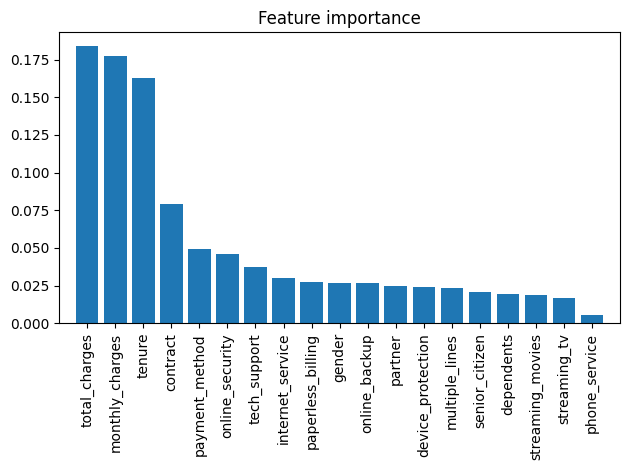

In [301]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = train_data.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train_std, y_train_encoded)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train_std.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature importance')
plt.bar(range(X_train_std.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train_std.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train_std.shape[1]])
plt.tight_layout()
# plt.savefig('figures/04_10.png', dpi=300)
plt.show()

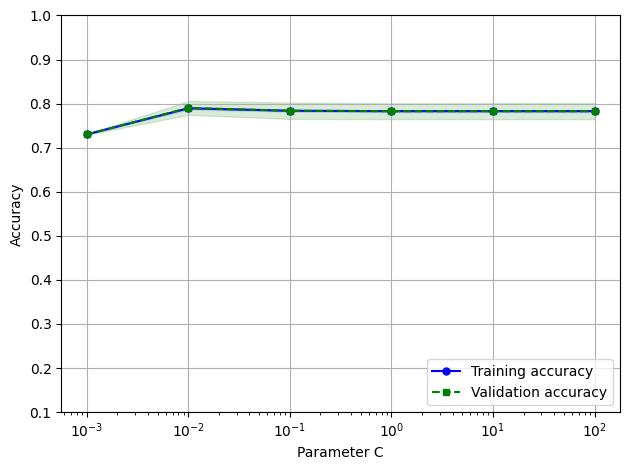

In [150]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(random_state=42, max_iter=10000))

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

train_scores, test_scores = validation_curve(
                estimator=pipe_lr,
                X=X_train_std,
                y=y_train_encoded,
                param_name='logisticregression__C',
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.0])
plt.tight_layout()
plt.show()

In [155]:
# Logistic Regression Classifier
lr = LogisticRegression(penalty='l2', C=0.3, solver='lbfgs', max_iter=10000)

pipe_lr = make_pipeline(StandardScaler(), lr)

# First, we train the model
pipe_lr.fit(X_train_std, y_train_encoded)

# Next, we predict and evaluate
y_pred_lr = pipe_lr.predict(X_test_encoded)

# Finally, we evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred_lr)
f1 = f1_score(y_test_encoded, y_pred_lr, average='binary')  # Use 'binary' for binary classification

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1-Score:", f1)

Logistic Regression Accuracy: 0.270254287403903
Logistic Regression F1-Score: 0.425512104283054


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [261]:
train_data_encoded.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Training accuracy: 0.8047172203905656
Test accuracy: 0.8001182732111177
gender
senior_citizen
partner
dependents
tenure
phone_service
multiple_lines
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies
contract
paperless_billing
payment_method
monthly_charges
total_charges


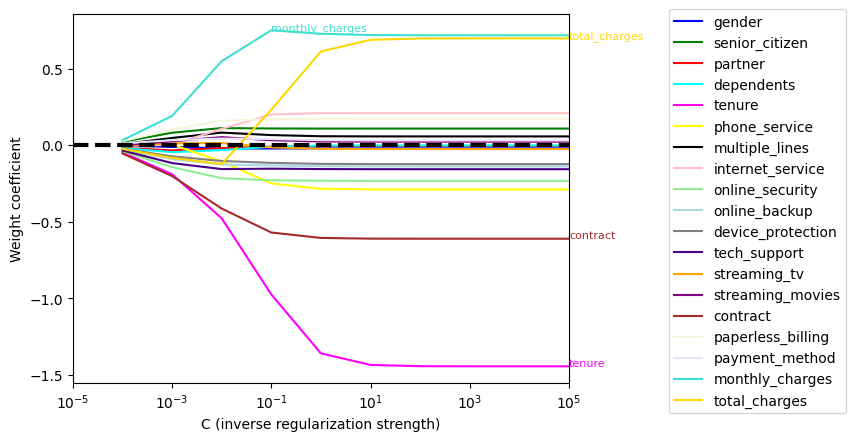

In [303]:
# L2 Regularization Visualization

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# Fit the initial logistic regression model
lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    multi_class='ovr',
    random_state=0
)
lr.fit(X_train_std, y_train_encoded)

print("Training accuracy:", lr.score(X_train_std, y_train_encoded))
print("Test accuracy:", lr.score(X_test_std, y_test_encoded))

# Initialize the plot
fig = plt.figure()
ax = plt.subplot(111)

# Define colors for plotting
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
    'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange',
    'purple', 'brown', 'beige', 'lavender', 'turquoise', 'gold',
    'salmon', 'teal', 'navy', 'lime', 'maroon', 'violet',
    'olive', 'chocolate', 'coral', 'darkred'
]

# Prepare to collect weights and regularization parameters
weights, params = [], []

# Train logistic regression models with varying C (inverse regularization strength)
for c in np.arange(-4., 6.):
    lr = LogisticRegression(
        penalty='l2',
        C=10**c,  # Corrected to 10**c for consistency
        solver='liblinear',
        random_state=0
    )
    lr.fit(X_train_std, y_train_encoded)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

# Plot the weight coefficients against C values
for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(
        params,
        weights[:, column],
        label=train_data_encoded.columns[column],
        color=color
    )
    label = train_data_encoded.columns[column]
    print(label)

    # Label features with weight coefficients greater than 0.5 or less than -0.5
    if ((weights[:, column] > 0.5) | (weights[:, column] < -0.5)).any():
        # Get the index where the maximum absolute weight occurs
        max_index = np.argmax(np.abs(weights[:, column]))
        plt.text(
            params[max_index],
            weights[max_index, column],
            label,
            color=color,
            fontsize=8
        )

# Add horizontal line at y=0
plt.axhline(0, color='black', linestyle='--', linewidth=3)

# Set plot parameters
plt.xlim([10**(-5), 10**5])
plt.ylabel('Weight coefficient')
plt.xlabel('C (inverse regularization strength)')
plt.xscale('log')
plt.legend(loc='upper left')

# Adjust legend placement
ax.legend(
    loc='upper center',
    bbox_to_anchor=(1.38, 1.03),
    ncol=1,
    fancybox=True
)

# Display the plot
plt.show()


#. 8 Model Deployment

In [ ]:
# Use the saved 'test_ids' from earlier preprocessing (which contains the original IDs)
# Ensure 'test_ids' matches the length of 'y_test_predictions'
churn_labels = ['Yes' if pred == 1 else 'No' for pred in y_test_predictions]

# Ensure the length of test_ids matches y_test_predictions (in case of any mismatch)
test_ids = test_ids[:len(y_test_predictions)]  # Slice test_ids to match length of predictions

# Create a submission file using 'test_ids' that was saved earlier
submission = pd.DataFrame({
    'id': test_ids,  # Using 'test_ids' that was saved earlier
    'label': churn_labels  # Changed column name to 'label'
})

# Save the submission file to CSV
submission.to_csv('submission.csv', index=False)





